In this assignment, you'll implement a L-layer deep model on MNIST dataset using Keras. The MNIST dataset contains tens of thousands of scanned images of handwritten digits, together with their correct classifications. MNIST's name comes from the fact that it is a modified subset of two data sets collected by NIST, the United States' National Institute of Standards and Technology.<br>
<br>
<br>
To use Keras, you'll need to install Keras and Tensorflow.
<br>
Please run the following commands if you don't have Keras and TensorFlow already installed.
<br>
1. ! pip install TensorFlow
<br>
2. ! pip install keras
<br>
3. ! pip install msgpack


In [4]:
import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import sklearn
import sklearn.datasets
import scipy

from PIL import Image
from scipy import ndimage


from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras import regularizers

np.random.seed(7)


%matplotlib inline

The MNIST dataset we use here is 'mnist.pkl.gz' which is divided into training, validation and test data. The following function <i> load_data() </i> unpacks the file and extracts the training, validation and test data.

In [5]:
def load_data():
    f = gzip.open('dataset/notracking/mnist.pkl.gz', 'rb')
    f.seek(0)
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    f.close()
    return (training_data, validation_data, test_data)

Let's see how the data looks:

In [6]:
training_data, validation_data, test_data = load_data()

In [33]:
training_data[1]

array([5, 0, 4, ..., 8, 4, 8])

In [8]:
print("The feature dataset is:" + str(training_data[0]))
print("The target dataset is:" + str(training_data[1]))
print("The number of examples in the training dataset is:" + str(len(training_data[0])))
print("The number of points in a single input is:" + str(len(training_data[0][1])))

The feature dataset is:[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
The target dataset is:[5 0 4 ... 8 4 8]
The number of examples in the training dataset is:50000
The number of points in a single input is:784


Now, as discussed earlier in the lectures, the target variable is converted to a one hot matrix. We use the function <i> one_hot </i> to convert the target dataset to one hot encoding.

In [9]:
def one_hot(j):
    # input is the target dataset of shape (1, m) where m is the number of data points
    # returns a 2 dimensional array of shape (10, m) where each target value is converted to a one hot encoding
    # Look at the next block of code for a better understanding of one hot encoding
    n = j.shape[0]
    new_array = np.zeros((10, n))
    index = 0
    for res in j:
        new_array[res][index] = 1.0
        index = index + 1
    return new_array

In [10]:
data = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7])
one_hot(data)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [11]:
def data_wrapper():
    tr_d, va_d, te_d = load_data()
    
    training_inputs = np.array(tr_d[0][:]).T
    training_results = np.array(tr_d[1][:])
    train_set_y = one_hot(training_results)
    
    validation_inputs = np.array(va_d[0][:]).T
    validation_results = np.array(va_d[1][:])
    validation_set_y = one_hot(validation_results)
    
    test_inputs = np.array(te_d[0][:]).T
    test_results = np.array(te_d[1][:])
    test_set_y = one_hot(test_results)
    
    return (training_inputs, train_set_y, validation_inputs, validation_set_y)

In [12]:
train_set_x, train_set_y, test_set_x, test_set_y = data_wrapper()

For implementing in Keras, the input training and input target dataset are supposed to have shape (m, n) where m is the number of training samples and n is the number of parts in a single input.
<br> Hence, let create the desired dataset shapes by taking transpose.

In [13]:
train_set_x = train_set_x.T
train_set_y = train_set_y.T
test_set_x = test_set_x.T
test_set_y = test_set_y.T

Now, let's see if the datasets are in the desired shape:

In [28]:
print (f"train_set_x shape: {train_set_x.shape} {type(train_set_x)}")
print (f"train_set_y shape: {train_set_y.shape} {type(train_set_y)}")
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x shape: (50000, 784) <class 'numpy.ndarray'>
train_set_y shape: (50000, 10) <class 'numpy.ndarray'>
test_set_x shape: (10000, 784)
test_set_y shape: (10000, 10)


Now let us visualise the dataset. Feel free to change the index to see if the training data has been correctly tagged.

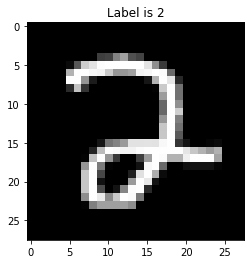

In [15]:
index  = 1800
k = train_set_x[index,:]
k = k.reshape((28, 28))
plt.title('Label is {}'.format(training_data[1][index]))
plt.imshow(k, cmap='gray')

Keras is a framework. So, to implement a neural network model in Keras, we first create an instance of Sequential(). <br>
The Sequential model is a linear stack of layers. We then keep adding Dense layers that are fully connected layers as we desire.<br><br>
We have included Dropout using <i> nn_model.add(Dropout(0.3)) </i> <br><br>
We can also include regularization using the command <br> <i> nn_model.add(Dense(21, activation='relu', kernel_regularizer=regularizers.l2(0.01))) </i> <br>instead of <br> <i> nn_model.add(Dense(21, activation='relu')) </i>

In [16]:
# create model
nn_model = Sequential()
nn_model.add(Dense(35, input_dim=784, activation='relu'))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(21, activation = 'relu'))
nn_model.add(Dense(10, activation='softmax'))

W0823 17:51:59.477902 139957738956608 deprecation_wrapper.py:119] From /home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 17:51:59.507199 139957738956608 deprecation_wrapper.py:119] From /home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 17:51:59.508539 139957738956608 deprecation_wrapper.py:119] From /home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 17:51:59.516870 139957738956608 deprecation_wrapper.py:119] From /home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python

Before we run the model on the training datasets, we compile the model in which we define various things like the loss function, the optimizer and the evaluation metric.

In [17]:
nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

W0823 17:51:59.548385 139957738956608 deprecation_wrapper.py:119] From /home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0823 17:51:59.562119 139957738956608 deprecation_wrapper.py:119] From /home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



Now, to fit the model on the training input and training target dataset, we run the following command using a minibatch of size 10 and 10 epochs.

In [18]:
nn_model.fit(train_set_x, train_set_y, epochs=10, batch_size=10)

W0823 17:51:59.626388 139957738956608 deprecation.py:323] From /home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
50000/50000 [==============================] - 3s 69us/step - loss: 0.5012 - acc: 0.8453
Epoch 2/10
50000/50000 [==============================] - 3s 66us/step - loss: 0.3248 - acc: 0.9000
Epoch 3/10
50000/50000 [==============================] - 3s 66us/step - loss: 0.2870 - acc: 0.9121
Epoch 4/10
50000/50000 [==============================] - 3s 67us/step - loss: 0.2641 - acc: 0.9170
Epoch 5/10
50000/50000 [==============================] - 3s 64us/step - loss: 0.2519 - acc: 0.9217
Epoch 6/10
50000/50000 [==============================] - 3s 64us/step - loss: 0.2438 - acc: 0.9228
Epoch 7/10
50000/50000 [==============================] - 3s 66us/step - loss: 0.2320 - acc: 0.9266
Epoch 8/10
50000/50000 [==============================] - 3s 64us/step - loss: 0.2246 - acc: 0.9293
Epoch 9/10
50000/50000 [==============================] - 3s 63us/step - loss: 0.2238 - acc: 0.9293
Epoch 10/10
50000/50000 [==============================] - 3s 66us/step - loss: 0.2214 - acc: 0.9293

In [19]:
scores_train = nn_model.evaluate(train_set_x, train_set_y)
print("\n%s: %.2f%%" % (nn_model.metrics_names[1], scores_train[1]*100))

50000/50000 [==============================] - 0s 8us/step

acc: 96.78%


We can see that the model has ~ 97% accuracy on the training dataset.

Now, let's make predictions on the test dataset.

In [20]:
predictions = nn_model.predict(test_set_x)
predictions = np.argmax(predictions, axis = 1)
predictions

array([3, 8, 6, ..., 5, 6, 8])

In [21]:
scores_test = nn_model.evaluate(test_set_x, test_set_y)
print("\n%s: %.2f%%" % (nn_model.metrics_names[1], scores_test[1]*100))

10000/10000 [==============================] - 0s 8us/step

acc: 96.21%


We can see that the model has ~96% accuracy on the training dataset.

Try and look at the different test cases and check which all have gone wrong. Feel free to change the index numbers.

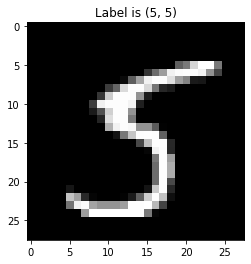

In [22]:
index  = 9997
k = test_set_x[index, :]
k = k.reshape((28, 28))
plt.title('Label is {label}'.format(label=(predictions[index], np.argmax(test_set_y, axis = 1)[index])))
plt.imshow(k, cmap='gray')

In [49]:
df = load_data()

X_train = np.concatenate((df[0][0], df[1][0], df[2][0]), axis=0)
y_train = np.concatenate((df[0][1], df[1][1], df[2][1]), axis=0)

(70000, 784)